# B-Cells Classification using VGG16
In this notebook, we will undertake cell classification using the VGG16 model as the foundational CNN.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.applications import VGG16
from keras.utils import plot_model

# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

Initially, it's essential to verify if hardware acceleration is enabled, as training a CNN on a CPU might be impractical.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# 256 Dense Neurons
To begin with, we will train a Multilayer Perceptron network for cell classification, using features extracted by VGG16 as input. In this process, the final layer of VGG16 is omitted, as it was originally designed for classifying the ImageNet dataset. During this phase of training, the VGG16 layers will be frozen.

In [ ]:
base_cnn = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False
base_cnn.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16")

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)               0     

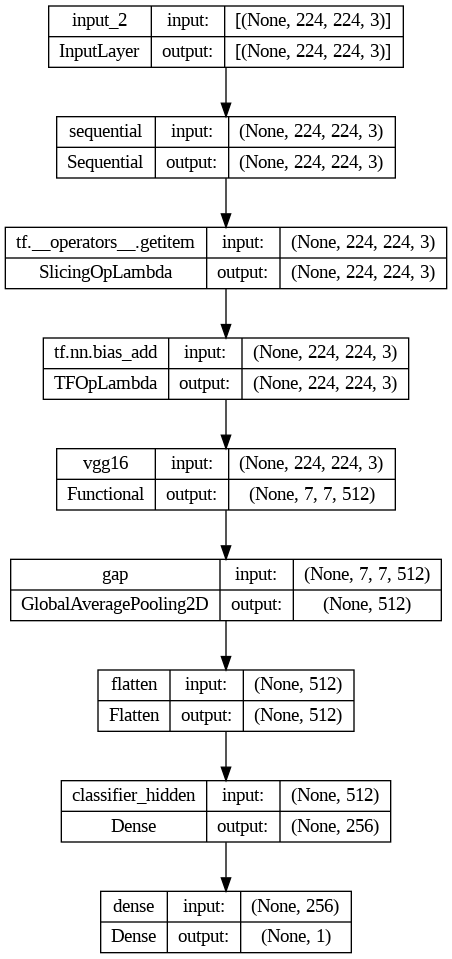

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6979
Epoch 1: val_loss improved from inf to 0.46808, saving model to /content/model/VGG16.h5
100/100 [==============================] - 72s 505ms/step - loss: 0.6028 - accuracy: 0.6979 - val_loss: 0.4681 - val_accuracy: 0.7960
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7514
Epoch 2: val_loss did not improve from 0.46808
100/100 [==============================] - 39s 381ms/step - loss: 0.5056 - accuracy: 0.7514 - val_loss: 0.4755 - val_accuracy: 0.7753
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7769
Epoch 3: val_loss improved from 0.46808 to 0.44343, saving model to /content/model/VGG16.h5
100/100 [==============================] - 40s 394ms/step - loss: 0.4714 - accuracy: 0.7769 - val_loss: 0.4434 - val_accuracy: 0.8096
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.7728
Epoch 4: val_loss improved from 0.44343 to 0.43196, saving model to /content/model/VGG16.h5
100/100 [==============================] - 39s 377ms/step - loss: 0.4655 - accuracy: 0.7728 - val_loss: 0.4320 - val_accuracy: 0.8161
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0

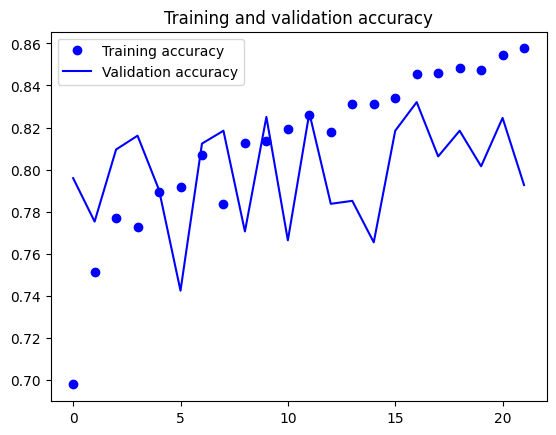

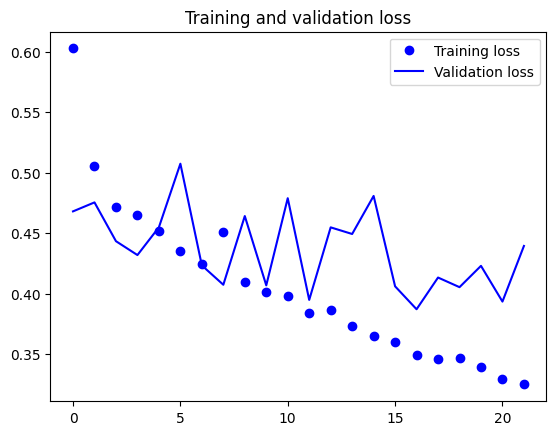

In [ ]:
model, history = run_model(model, "VGG16", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 13s 365ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8784    0.8886    0.8835      1463
         hem     0.7504    0.7313    0.7407       670

    accuracy                         0.8392      2133
   macro avg     0.8144    0.8100    0.8121      2133
weighted avg     0.8382    0.8392    0.8386      2133



34/34 [==============================] - 9s 273ms/step


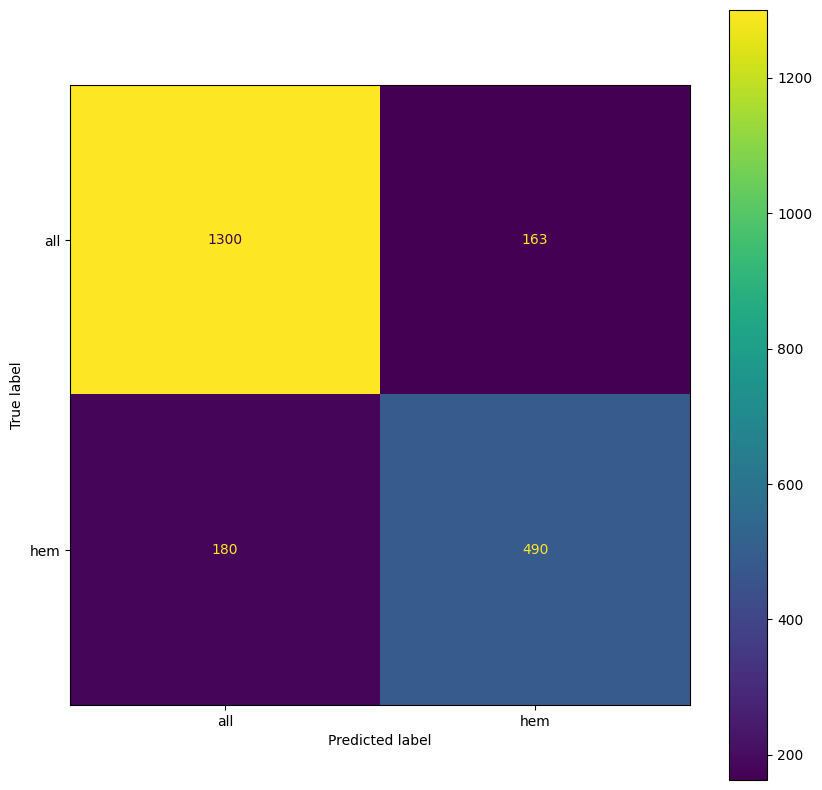

In [ ]:
plot_confusionmatrix(model, test_ds)

# 256 Dense Neurons, Dropout
The performance of the last model is not satisfactory. To address this issue, we will attempt to improve it by incorporating dropout.

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_Dropout")

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VGG16_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)             

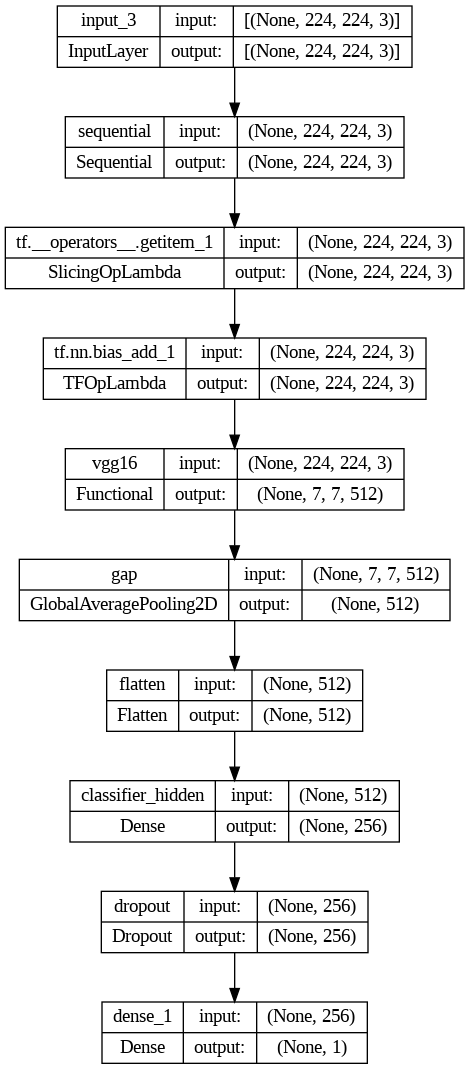

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.6615
Epoch 1: val_loss improved from inf to 0.49408, saving model to /content/model/VGG16_Dropout.h5
100/100 [==============================] - 40s 369ms/step - loss: 0.8399 - accuracy: 0.6615 - val_loss: 0.4941 - val_accuracy: 0.7824


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7148
Epoch 2: val_loss did not improve from 0.49408
100/100 [==============================] - 38s 373ms/step - loss: 0.5579 - accuracy: 0.7148 - val_loss: 0.5169 - val_accuracy: 0.7580
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7448
Epoch 3: val_loss did not improve from 0.49408
100/100 [==============================] - 39s 378ms/step - loss: 0.5283 - accuracy: 0.7448 - val_loss: 0.5093 - val_accuracy: 0.7636
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.7578
Epoch 4: val_loss did not improve from 0.49408
100/100 [==============================] - 39s 382ms/step - loss: 0.5096 - accuracy: 0.7578 - val_loss: 0.5302 - val_accuracy: 0.7491
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.7539
Epoch 5: val_loss improved from 0.49408 to 0.48221, saving model to /cont

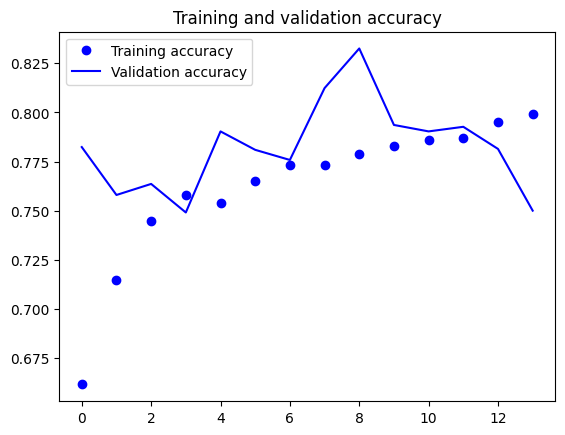

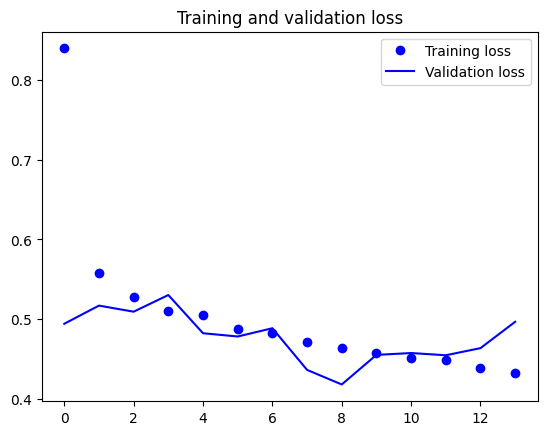

In [ ]:
model, history = run_model(model, "VGG16_Dropout", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 268ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8549    0.8982    0.8760      1463
         hem     0.7500    0.6672    0.7062       670

    accuracy                         0.8256      2133
   macro avg     0.8025    0.7827    0.7911      2133
weighted avg     0.8220    0.8256    0.8227      2133



34/34 [==============================] - 9s 267ms/step


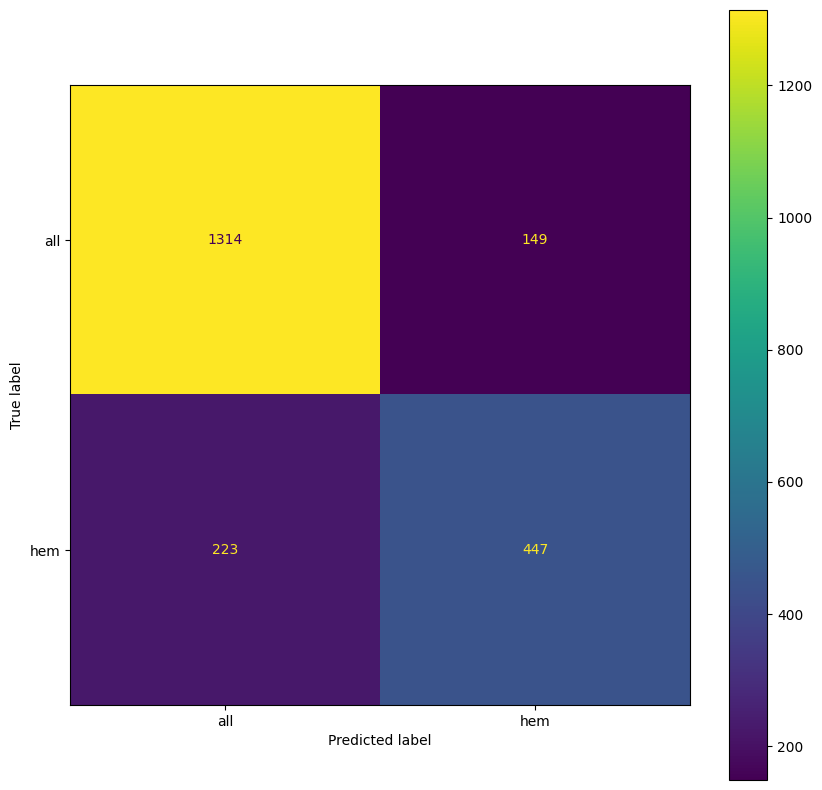

In [ ]:
plot_confusionmatrix(model, test_ds)

# 512 Dense Neurons, Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_Dropout03_512Dense")

model = compile_model(model, loss="binary_crossentropy")
model.summary()


Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

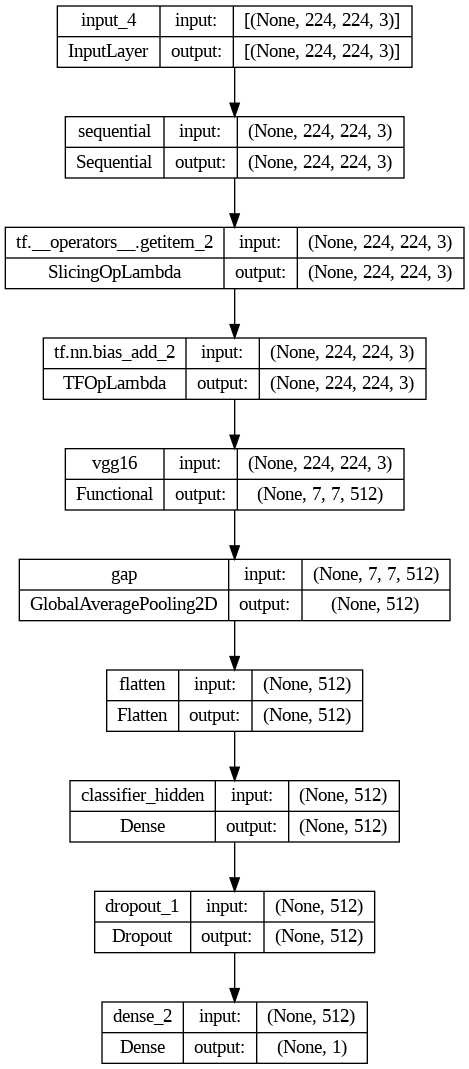

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6626
Epoch 1: val_loss improved from inf to 0.46477, saving model to /content/model/VGG16_Dropout03_512Dense.h5
100/100 [==============================] - 42s 383ms/step - loss: 0.8308 - accuracy: 0.6626 - val_loss: 0.4648 - val_accuracy: 0.7772
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.7316
Epoch 2: val_loss improved from 0.46477 to 0.44387, saving model to /content/model/VGG16_Dropout03_512Dense.h5
100/100 [==============================] - 39s 379ms/step - loss: 0.5525 - accuracy: 0.7316 - val_loss: 0.4439 - val_accuracy: 0.7950
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7563
Epoch 3: val_loss did not improve from 0.44387
100/100 [==============================] - 38s 374ms/step - loss: 0.5045 - accuracy: 0.7563 - val_loss: 0.4826 - val_accuracy: 0.7688
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.7649
Epoch 4: val_loss did not improve from 0.44387
100/100 [==============================] - 39s 383ms/step - loss: 0.4811 - accuracy: 0.7649 - val_loss: 0.4736 - val_accuracy: 0.7781
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.7731
Epoch 5: val_loss im

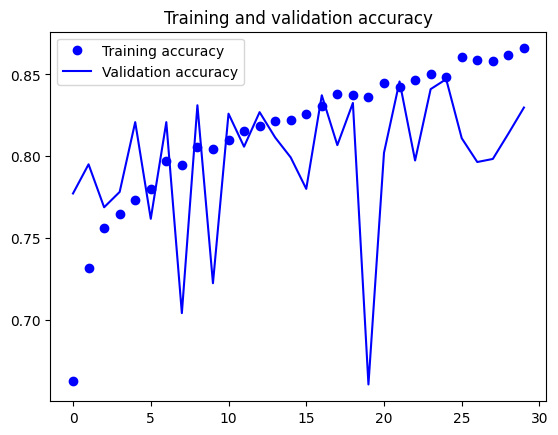

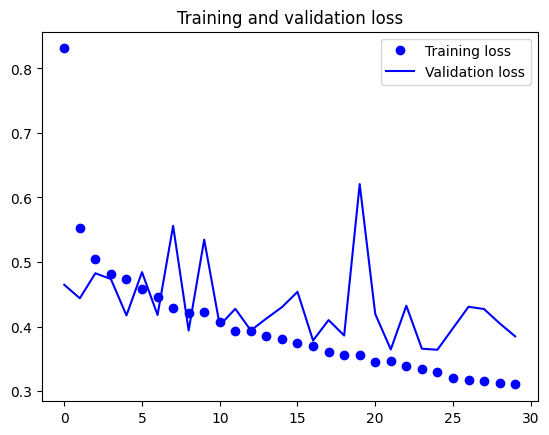

In [ ]:
model, history = run_model(model, "VGG16_Dropout03_512Dense", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 265ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8827    0.8845    0.8836      1463
         hem     0.7466    0.7433    0.7450       670

    accuracy                         0.8401      2133
   macro avg     0.8147    0.8139    0.8143      2133
weighted avg     0.8399    0.8401    0.8400      2133



34/34 [==============================] - 9s 265ms/step


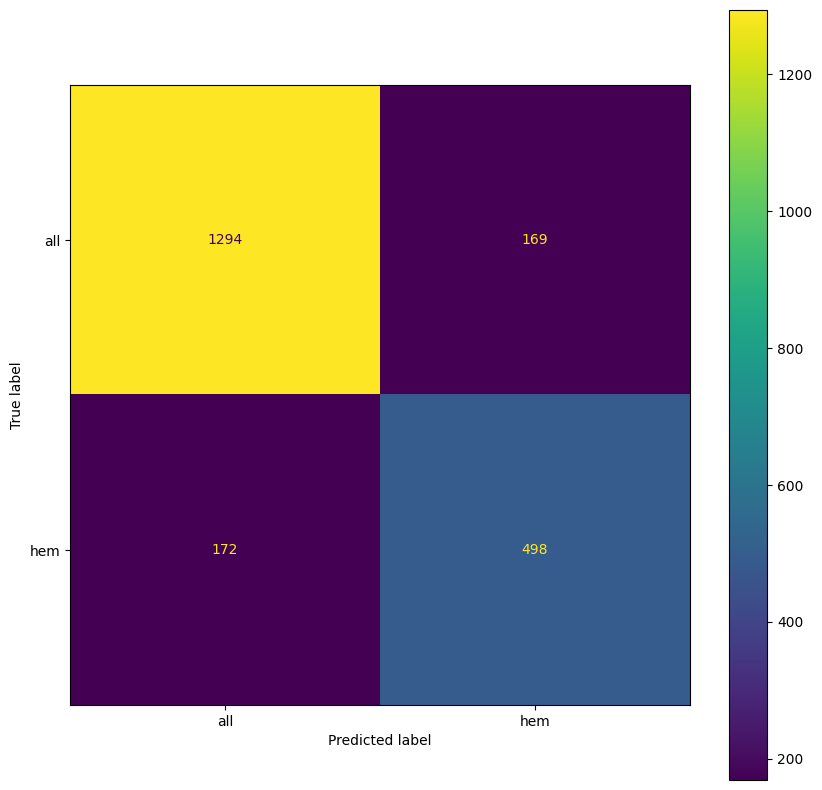

In [ ]:
plot_confusionmatrix(model, test_ds)

# Fine Tuning
Now, it's time to unfreeze the last block of VGG16 and fine-tune its weights on our dataset. We will proceed with the last model, which includes dropout and a hidden classifier layer consisting of 512 neurons, as it demonstrated the best performance.

## Unfreezing last layer

In [ ]:
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Models/VGG16_Dropout03_512Dense/VGG16_Dropout03_512Dense.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

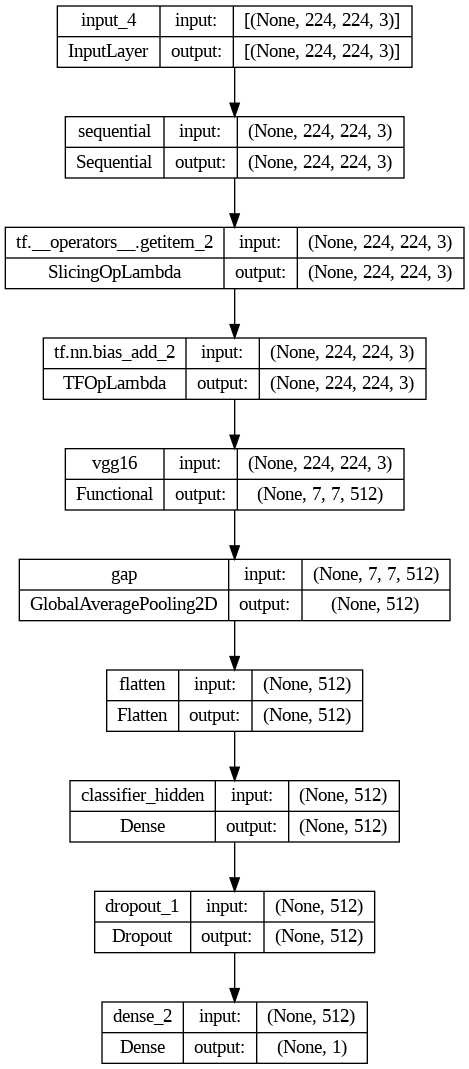

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.6890
Epoch 1: val_loss improved from inf to 0.45111, saving model to /content/model/VGG16_LastLayerFineTuned.h5
100/100 [==============================] - 40s 372ms/step - loss: 0.8549 - accuracy: 0.6890 - val_loss: 0.4511 - val_accuracy: 0.8063


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7603
Epoch 2: val_loss improved from 0.45111 to 0.40573, saving model to /content/model/VGG16_LastLayerFineTuned.h5
100/100 [==============================] - 38s 372ms/step - loss: 0.5006 - accuracy: 0.7603 - val_loss: 0.4057 - val_accuracy: 0.8208
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.7619
Epoch 3: val_loss improved from 0.40573 to 0.38156, saving model to /content/model/VGG16_LastLayerFineTuned.h5
100/100 [==============================] - 38s 369ms/step - loss: 0.4785 - accuracy: 0.7619 - val_loss: 0.3816 - val_accuracy: 0.8391
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.7899
Epoch 4: val_loss improved from 0.38156 to 0.37958, saving model to /content/model/VGG16_LastLayerFineTuned.h5
100/100 [==============================] - 39s 381ms/step - loss: 0.4421 - accuracy: 0.7899 - val_loss: 0.3796 

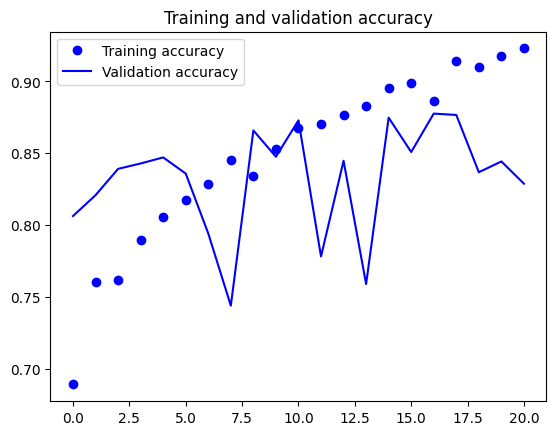

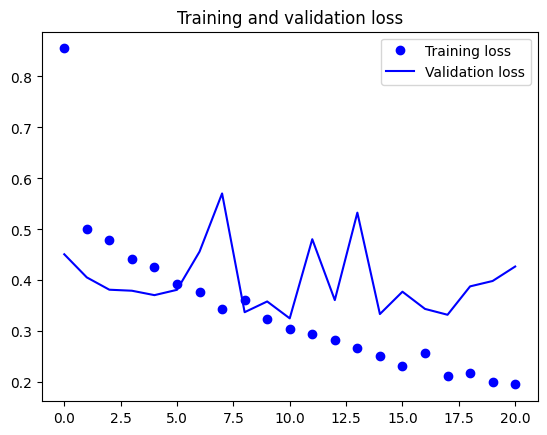

In [ ]:
model, history = run_model(model, "VGG16_LastLayerFineTuned", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 251ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8992    0.9146    0.9068      1463
         hem     0.8062    0.7761    0.7909       670

    accuracy                         0.8711      2133
   macro avg     0.8527    0.8453    0.8488      2133
weighted avg     0.8700    0.8711    0.8704      2133



34/34 [==============================] - 8s 248ms/step


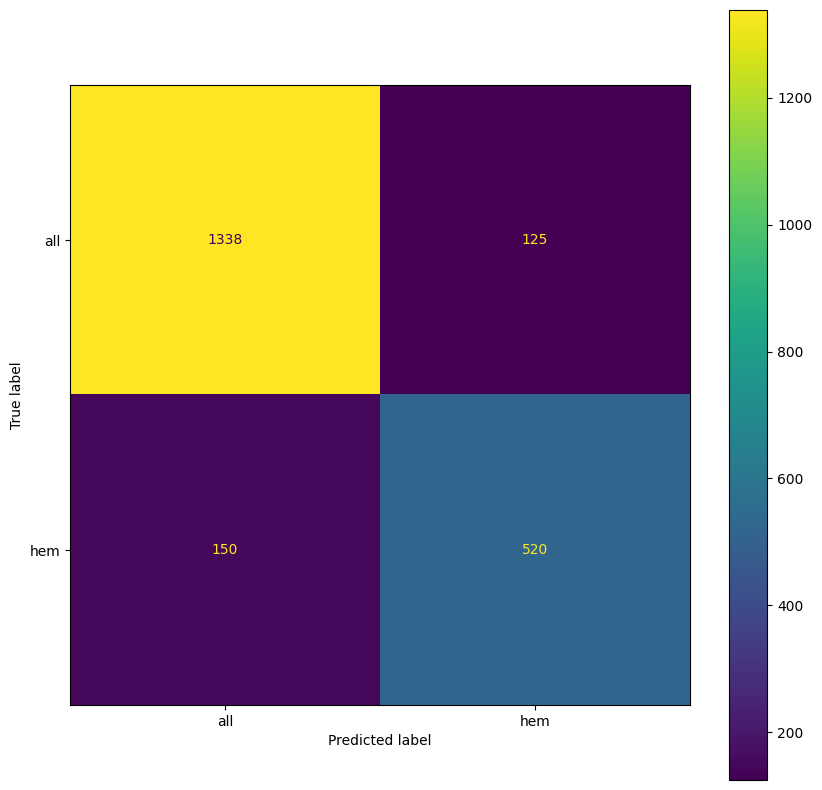

In [ ]:
plot_confusionmatrix(model, test_ds)

## Unfreezing last 2 layers
We will experiment with unfreezing the second-to-last layer, but instead of loading the model with the entire VGG16 block frozen, we will employ the last model and apply a gradual fine-tuning process to the second-to-last layer, considering that the weights of the last layer have already been fine-tuned.

In [ ]:
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Models/VGG16_LastLayerFineTuned/VGG16_LastLayerFineTuned.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

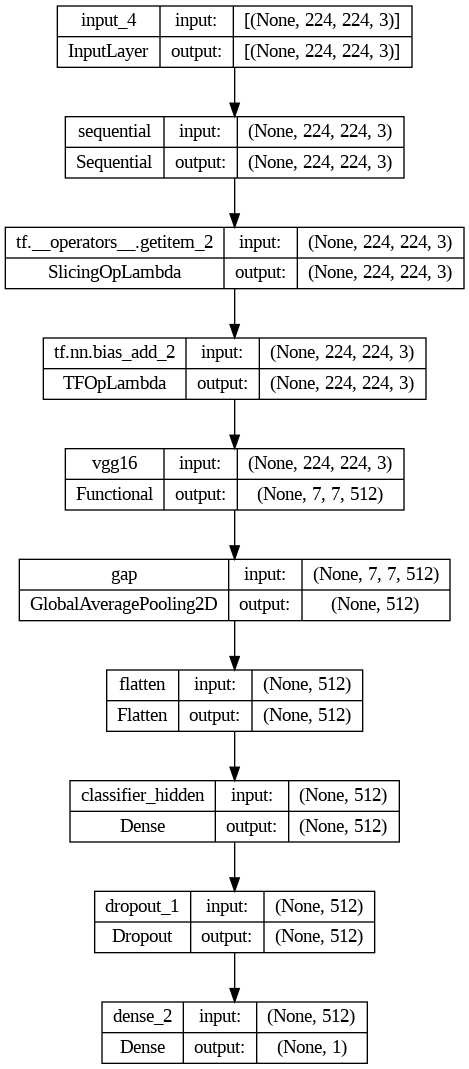

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.6918
Epoch 1: val_loss improved from inf to 0.52391, saving model to /content/model/VGG16_Last2LayersFineTuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 291s 3s/step - loss: 1.1543 - accuracy: 0.6918 - val_loss: 0.5239 - val_accuracy: 0.7767
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7184
Epoch 2: val_loss improved from 0.52391 to 0.44711, saving model to /content/model/VGG16_Last2LayersFineTuned.h5
100/100 [==============================] - 39s 385ms/step - loss: 0.5542 - accuracy: 0.7184 - val_loss: 0.4471 - val_accuracy: 0.7974
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7348
Epoch 3: val_loss did not improve from 0.44711
100/100 [==============================] - 40s 393ms/step - loss: 0.5316 - accuracy: 0.7348 - val_loss: 0.6115 - val_accuracy: 0.6787
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.7470
Epoch 4: val_loss did not improve from 0.44711
100/100 [==============================] - 42s 405ms/step - loss: 0.5078 - accuracy: 0.7470 - val_loss: 0

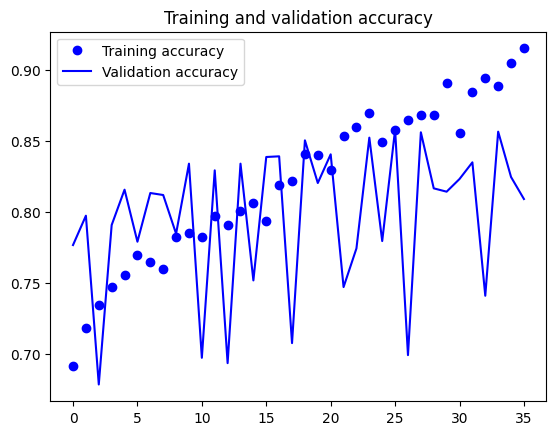

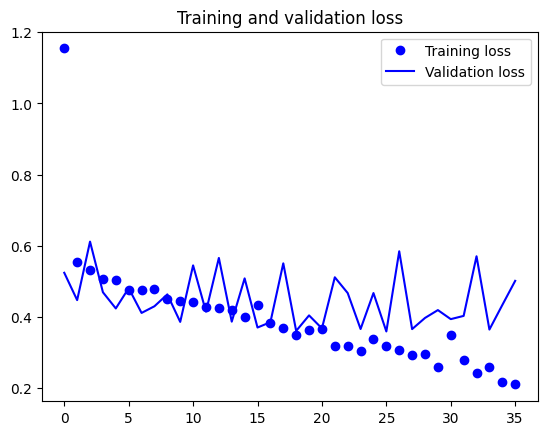

In [ ]:
model, history = run_model(model, "VGG16_Last2LayersFineTuned", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 12s 361ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8847    0.9077    0.8961      1463
         hem     0.7864    0.7418    0.7634       670

    accuracy                         0.8556      2133
   macro avg     0.8356    0.8248    0.8298      2133
weighted avg     0.8539    0.8556    0.8544      2133



34/34 [==============================] - 9s 271ms/step


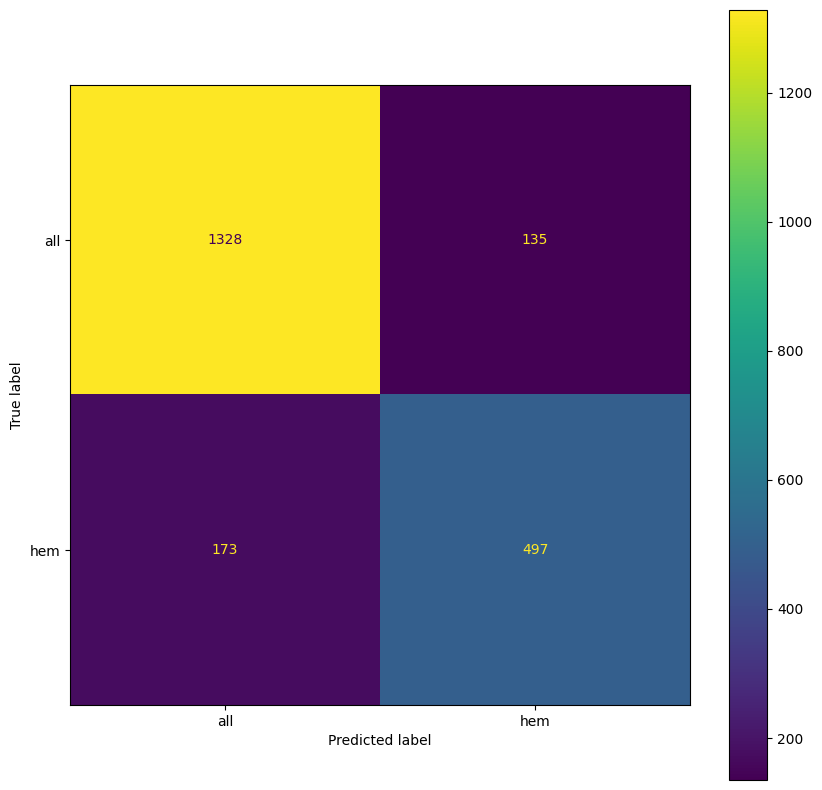

In [ ]:
plot_confusionmatrix(model, test_ds)

Now, let's reload the model and retrain it using a reduced learning rate.

In [ ]:
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Models/VGG16_LastLayerFineTuned/VGG16_LastLayerFineTuned.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="binary_crossentropy", learning_rate=0.0001)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

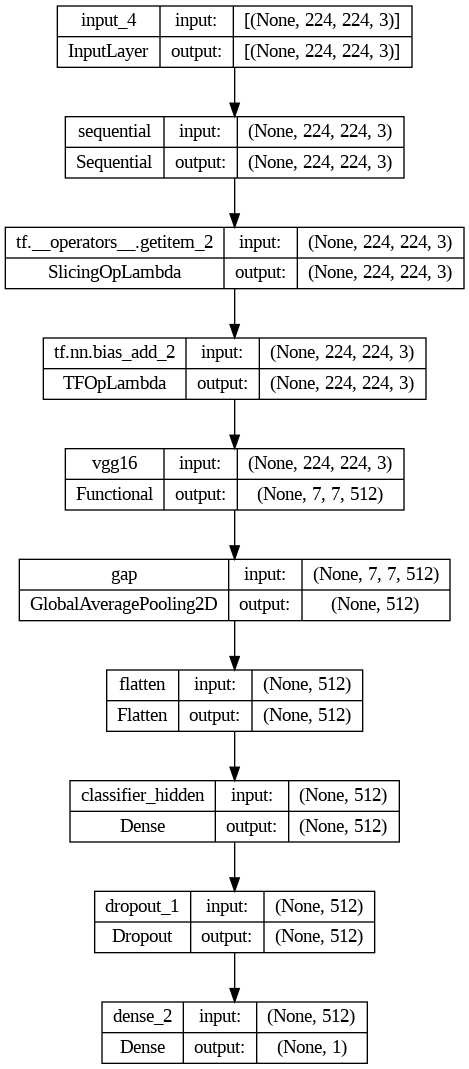

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8268
Epoch 1: val_loss improved from inf to 0.36936, saving model to /content/model/VGG16_Last2LayersFineTuned_ReducedLR.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 45s 404ms/step - loss: 0.4011 - accuracy: 0.8268 - val_loss: 0.3694 - val_accuracy: 0.8518
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8771
Epoch 2: val_loss did not improve from 0.36936
100/100 [==============================] - 42s 411ms/step - loss: 0.2849 - accuracy: 0.8771 - val_loss: 0.5017 - val_accuracy: 0.7777
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8724
Epoch 3: val_loss improved from 0.36936 to 0.33810, saving model to /content/model/VGG16_Last2LayersFineTuned_ReducedLR.h5
100/100 [==============================] - 42s 408ms/step - loss: 0.2853 - accuracy: 0.8724 - val_loss: 0.3381 - val_accuracy: 0.8701
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8848
Epoch 4: val_loss did not improve from 0.33810
100/100 [==============================] - 41s 401ms/step - loss: 0.2624 - accuracy: 0.8848 -

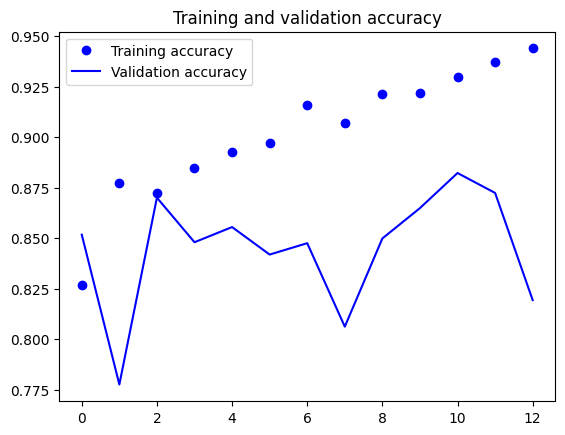

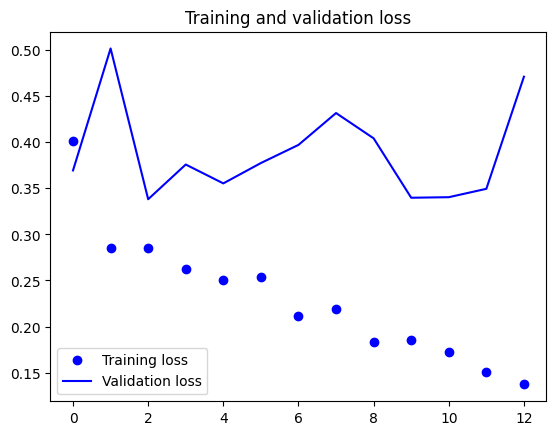

In [ ]:
model, history = run_model(model, "VGG16_Last2LayersFineTuned_ReducedLR", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 266ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8933    0.8927    0.8930      1463
         hem     0.7660    0.7672    0.7666       670

    accuracy                         0.8533      2133
   macro avg     0.8297    0.8299    0.8298      2133
weighted avg     0.8533    0.8533    0.8533      2133



34/34 [==============================] - 9s 271ms/step


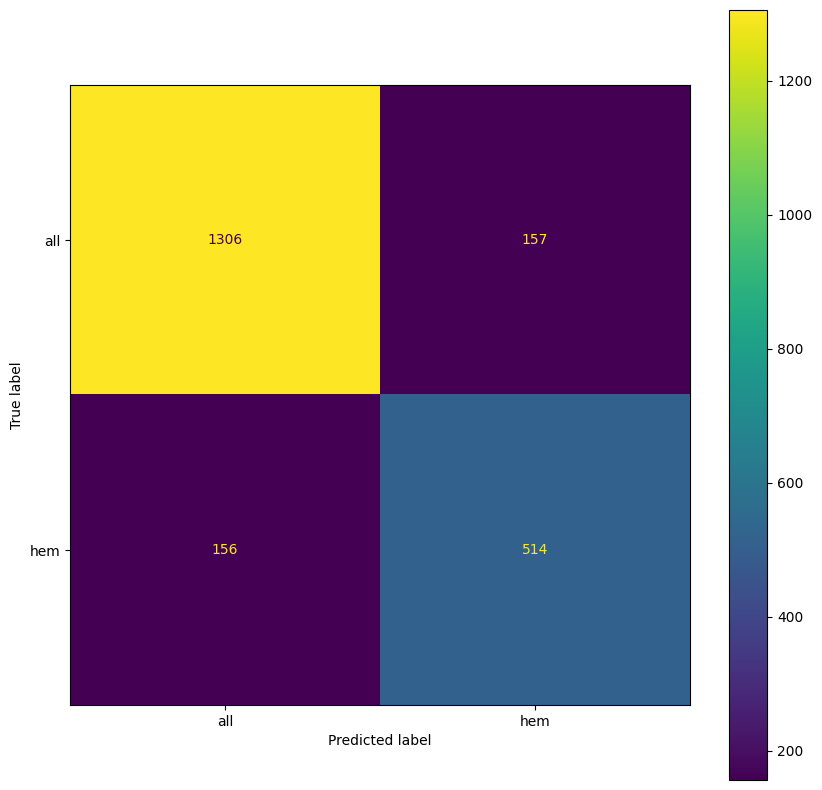

In [ ]:
plot_confusionmatrix(model, test_ds)

## Unfreezing the whole last block
Building upon the last trained model, we will ultimately unfreeze the entire last block.

In [1]:
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Models/VGG16_Last2LayersFineTuned_ReducedLR/VGG16_Last2LayersFineTuned_ReducedLR.h5')

NameError: ignored

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="binary_crossentropy",learning_rate=0.0001)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

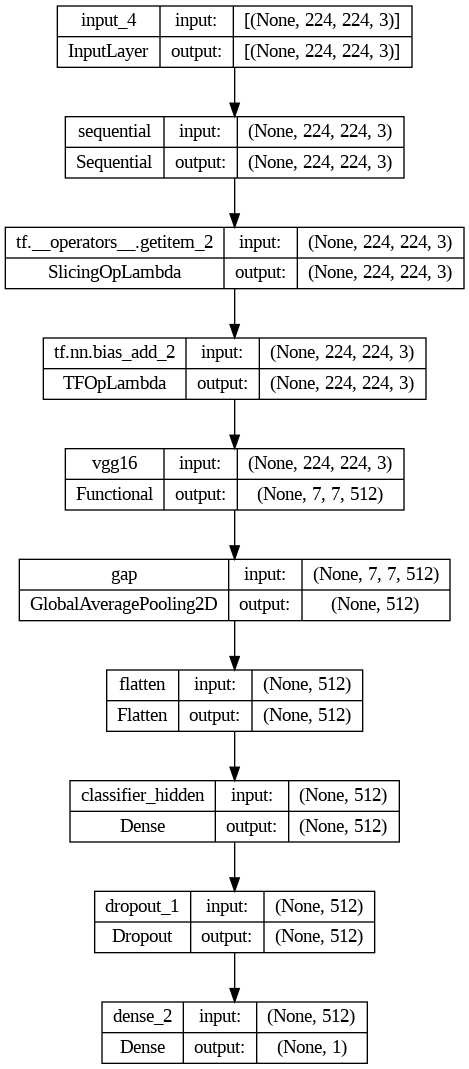

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8007
Epoch 1: val_loss improved from inf to 0.47077, saving model to /content/model/VGG16_LastBlockFineTuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 47s 437ms/step - loss: 0.4578 - accuracy: 0.8007 - val_loss: 0.4708 - val_accuracy: 0.7613
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8430
Epoch 2: val_loss did not improve from 0.47077
100/100 [==============================] - 42s 418ms/step - loss: 0.3418 - accuracy: 0.8430 - val_loss: 0.4849 - val_accuracy: 0.7538
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8710
Epoch 3: val_loss improved from 0.47077 to 0.36694, saving model to /content/model/VGG16_LastBlockFineTuned.h5
100/100 [==============================] - 42s 414ms/step - loss: 0.2936 - accuracy: 0.8710 - val_loss: 0.3669 - val_accuracy: 0.8279
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.8898
Epoch 4: val_loss improved from 0.36694 to 0.36293, saving model to /content/model/VGG16_LastBlockFineTuned.h5
100/100 [==============================] 

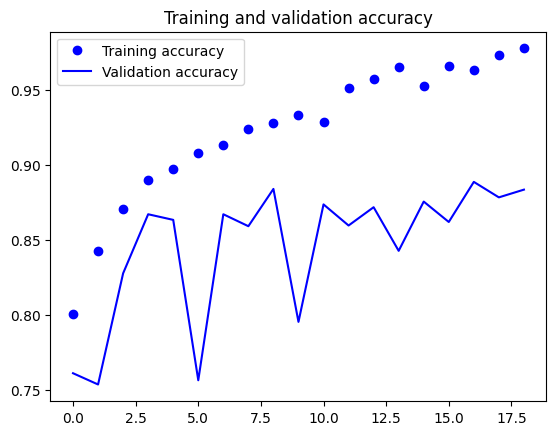

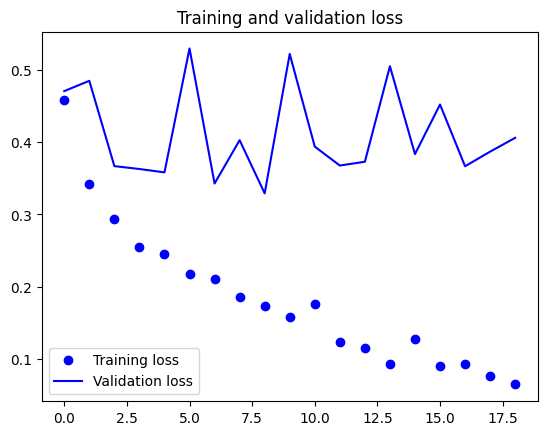

In [ ]:
model, history = run_model(model, "VGG16_LastBlockFineTuned", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 259ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9043    0.9364    0.9201      1463
         hem     0.8495    0.7836    0.8152       670

    accuracy                         0.8884      2133
   macro avg     0.8769    0.8600    0.8676      2133
weighted avg     0.8871    0.8884    0.8871      2133



34/34 [==============================] - 9s 265ms/step


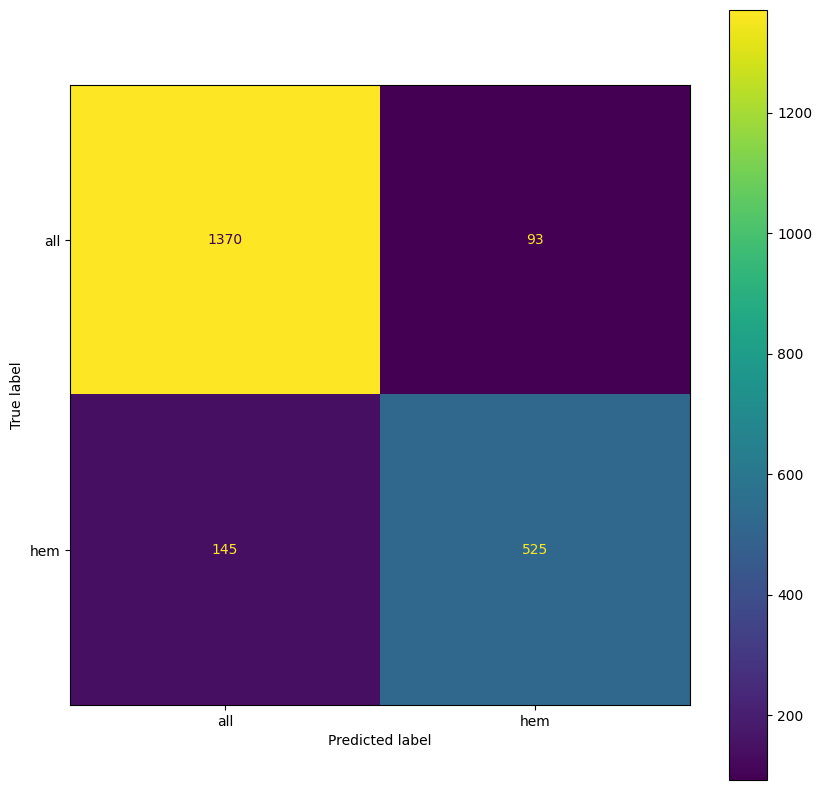

In [ ]:
plot_confusionmatrix(model, test_ds)

### Unfreezing the last block not progressively
We will now take a different approach by completely unfreezing the last block and fine-tuning it. This allows us to compare the performance with the models that were progressively unfrozen.

In [ ]:
model = models.load_model(MODELS_PATH + '/VGG16_Dropout03_512Dense/VGG16_Dropout03_512Dense.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="binary_crossentropy",learning_rate = 0.0001)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2  (None, 512)  

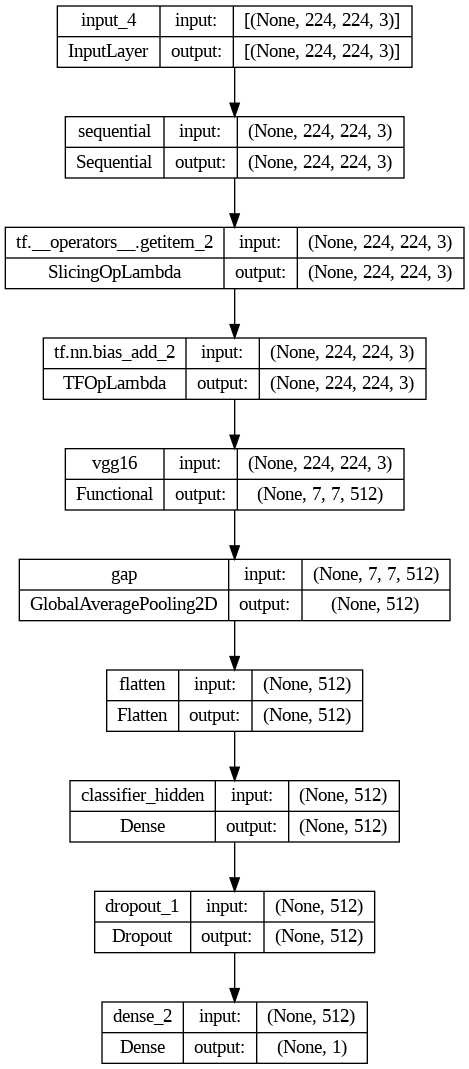

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7231 
Epoch 1: val_loss improved from inf to 0.41758, saving model to /content/model/VGG16_LastBlockFineTunedEntirely.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 1522s 14s/step - loss: 0.6526 - accuracy: 0.7231 - val_loss: 0.4176 - val_accuracy: 0.8250
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7799
Epoch 2: val_loss improved from 0.41758 to 0.36013, saving model to /content/model/VGG16_LastBlockFineTunedEntirely.h5
100/100 [==============================] - 40s 393ms/step - loss: 0.4547 - accuracy: 0.7799 - val_loss: 0.3601 - val_accuracy: 0.8462
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8130
Epoch 3: val_loss did not improve from 0.36013
100/100 [==============================] - 38s 375ms/step - loss: 0.4078 - accuracy: 0.8130 - val_loss: 0.3650 - val_accuracy: 0.8574
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.8371
Epoch 4: val_loss did not improve from 0.36013
100/100 [==============================] - 41s 400ms/step - loss: 0.3715 - accuracy: 0.8371 - val

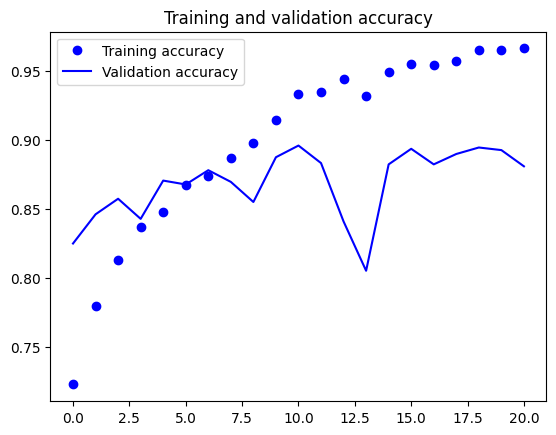

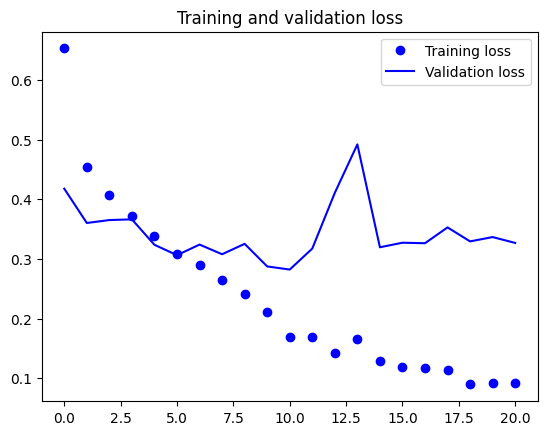

In [ ]:
model, history = run_model(model, "VGG16_LastBlockFineTunedEntirely", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 387s 11s/step
Classification report:
              precision    recall  f1-score   support

         all     0.9107    0.9275    0.9191      1463
         hem     0.8351    0.8015    0.8180       670

    accuracy                         0.8880      2133
   macro avg     0.8729    0.8645    0.8685      2133
weighted avg     0.8870    0.8880    0.8873      2133



34/34 [==============================] - 8s 240ms/step


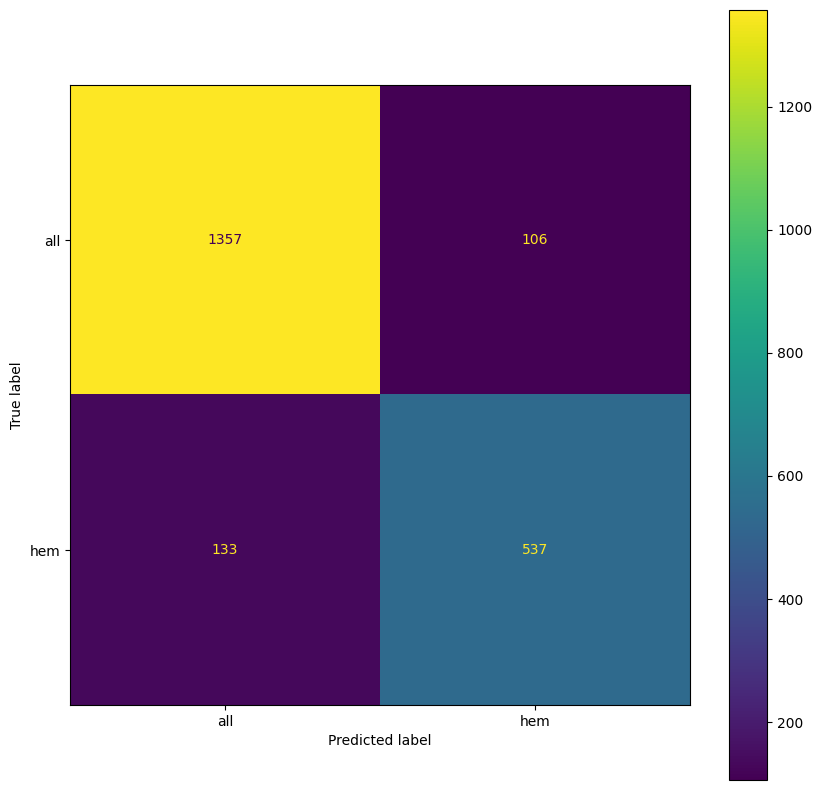

In [ ]:
plot_confusionmatrix(model, test_ds)